## Linestrings buffer

Nesse notebook são construídas as linestrings dos ônibus e aplicado um buffer.

In [1]:
import geopandas as gpd
from shapely.geometry import LineString
from utils.load_csv import load_csv
from utils.save_shp import save_shp

In [2]:
df_onibus = load_csv('calculo-distancia-percorrida_2025-10-19_silver_corrigido.csv')

In [3]:
BUFFER = 10

In [4]:
df_onibus.head()

,hora_requisicao,codigo_linha,nome_linha,letreiro,codigo_onibus,x,y,hora_gps,geometry,ponto_final,hora_final,distancia_percorrida,segundos_deslocamento
0,00:03:00,33873,414P-10,TERM. NORTE METRÔ CARRÃO - VL. INDUSTRIAL,3117,-46.538514,-23.580873,2025-10-19 00:03:41-03:00,POINT (343000.57434797107 7391331.953175336),POINT (343564.72064182337 7390723.713612563),2025-10-19 00:06:41-03:00,829.588095,180.0
1,00:06:00,33873,414P-10,TERM. NORTE METRÔ CARRÃO - VL. INDUSTRIAL,3117,-46.533051,-23.586420,2025-10-19 00:06:41-03:00,POINT (343564.72064182337 7390723.713612563),POINT (344148.79497202416 7389881.602579644),2025-10-19 00:09:41-03:00,1024.838434,180.0
2,00:09:00,33873,414P-10,TERM. NORTE METRÔ CARRÃO - VL. INDUSTRIAL,3117,-46.527417,-23.594081,2025-10-19 00:09:41-03:00,POINT (344148.79497202416 7389881.602579644),POINT (343755.0927053654 7388192.974536229),2025-10-19 00:17:09-03:00,1733.916418,448.0
3,00:17:00,33873,414P-10,TERM. NORTE METRÔ CARRÃO - VL. INDUSTRIAL,3117,-46.531451,-23.609290,2025-10-19 00:17:09-03:00,POINT (343755.0927053654 7388192.974536229),POINT (343935.86315401876 7388075.135070228),2025-10-19 00:18:42-03:00,215.787152,93.0
4,00:18:00,33873,414P-10,TERM. NORTE METRÔ CARRÃO - VL. INDUSTRIAL,3117,-46.529692,-23.610371,2025-10-19 00:18:42-03:00,POINT (343935.86315401876 7388075.135070228),POINT (352409.5177851509 7386741.7130298335),2025-10-19 06:57:33-03:00,8577.927322,23931.0


In [5]:
gdf_onibus = gpd.GeoDataFrame(df_onibus, geometry = gpd.points_from_xy(df_onibus.x, df_onibus.y), crs = 'EPSG:4326')

gdf_onibus = gdf_onibus.to_crs('EPSG:31983')

In [6]:
gdf_onibus = gdf_onibus.sort_values(['codigo_onibus', 'hora_gps']).reset_index(drop = True)

counts = gdf_onibus.codigo_onibus.value_counts()

remover = counts[counts < 2].index

gdf_onibus = gdf_onibus[~gdf_onibus.codigo_onibus.isin(remover)]

In [7]:
linhas = []

for codigo, grupo in gdf_onibus.groupby('codigo_onibus'):

    pts = grupo.geometry.tolist()
    horas = grupo.hora_gps.tolist()

    for i in range(len(pts) - 1):
        if pts[i] != pts[i+1]:
            linhas.append({
                'codigo_onibus': codigo,
                'codigo_linha': grupo.codigo_linha.iloc[0],
                'ponto_inicio': pts[i],
                'ponto_fim': pts[i+1],
                'hora_inicio': horas[i],
                'hora_fim': horas[i+1],
                'geometry': LineString([pts[i], pts[i+1]])
            })

gdf_trajetos = gpd.GeoDataFrame(linhas, geometry = 'geometry', crs = 'EPSG:31983')

In [8]:
gdf_trajetos['buffer'] = gdf_trajetos.geometry.buffer(BUFFER)

In [9]:
gdf_trajetos.head()

,codigo_onibus,codigo_linha,ponto_inicio,ponto_fim,hora_inicio,hora_fim,geometry,buffer
0,3117,33873,POINT (343000.57434797107 7391331.953175336),POINT (343564.72064182337 7390723.713612563),2025-10-19 00:03:41-03:00,2025-10-19 00:06:41-03:00,"LINESTRING (343000.574 7391331.953, 343564.721...","POLYGON ((343572.052 7390730.514, 343572.684 7..."
1,3117,33873,POINT (343564.72064182337 7390723.713612563),POINT (344148.79497202416 7389881.602579644),2025-10-19 00:06:41-03:00,2025-10-19 00:09:41-03:00,"LINESTRING (343564.721 7390723.714, 344148.795...","POLYGON ((344157.012 7389887.302, 344157.531 7..."
2,3117,33873,POINT (344148.79497202416 7389881.602579644),POINT (343755.0927053654 7388192.974536229),2025-10-19 00:09:41-03:00,2025-10-19 00:17:09-03:00,"LINESTRING (344148.795 7389881.603, 343755.093...","POLYGON ((343764.832 7388190.704, 343764.562 7..."
3,3117,33873,POINT (343755.0927053654 7388192.974536229),POINT (343935.86315401876 7388075.135070228),2025-10-19 00:17:09-03:00,2025-10-19 00:18:42-03:00,"LINESTRING (343755.093 7388192.975, 343935.863...","POLYGON ((343941.324 7388083.512, 343942.119 7..."
4,3117,33873,POINT (343935.86315401876 7388075.135070228),POINT (352409.5177851509 7386741.7130298335),2025-10-19 00:18:42-03:00,2025-10-19 06:57:33-03:00,"LINESTRING (343935.863 7388075.135, 352409.518...","POLYGON ((352411.072 7386751.591, 352412.033 7..."


<Axes: >

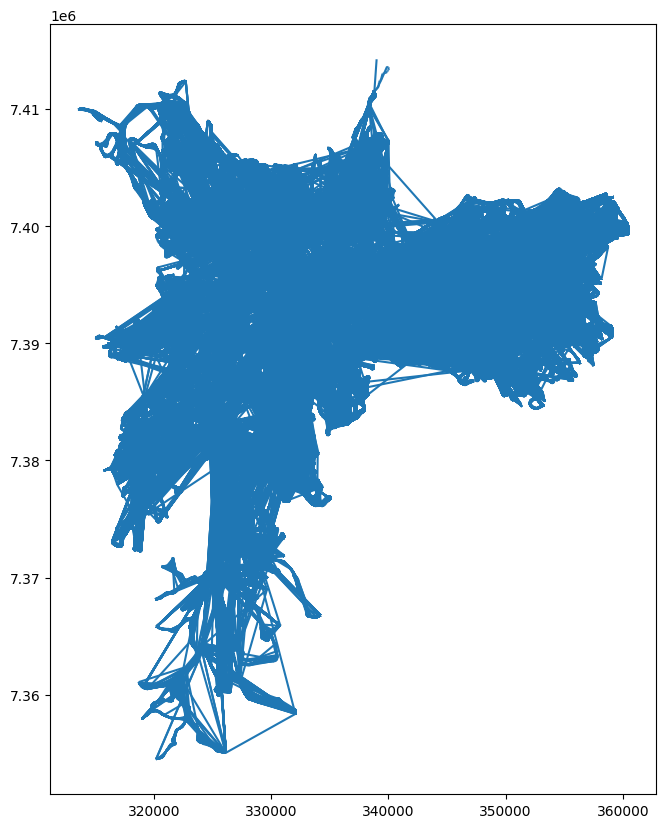

In [10]:
gdf_trajetos.plot(figsize = (10, 10))

In [11]:
gdf_trajetos = gdf_trajetos.set_geometry('buffer')

gdf_trajetos = gdf_trajetos.drop(columns = ['geometry'])

In [13]:
gdf_trajetos = gdf_trajetos.rename(columns = {'codigo_onibus': 'cd_onibus', 
                                              'codigo_linha': 'cd_linha', 
                                              'ponto_inicio': 'pt_inicio', 
                                              'ponto_fim': 'pt_fim', 
                                              'hora_inicio': 'hr_inicio', 
                                              'hora_fim': 'hr_fim'})

In [14]:
save_shp(gdf_trajetos, 'gdf_trajetos.shp')

c:\Users\x050258\projetos\onibus_eletricos_saude\.venv\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: 2GB file size limit reached for data\gdf_trajetos.shp. Going on, but might cause compatibility issues with third party software
  ogr_write(


Shapefile salvo em data\gdf_trajetos.shp
